## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !unzip gdrive/MyDrive/datasets-oxpet.zip

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
import os
import h5py
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class Oxpet_Dataset(Dataset):
    def __init__(self, img_path, binary_path, bboxes_path, masks_path, require_binary = True, require_bbox = True, require_masks = True):
        self.img_path = img_path
        self.require_binary = require_binary
        self.require_bbox = require_bbox
        self.require_masks = require_masks
        if self.require_binary:
            self.binary_path = binary_path
        if self.require_bbox:
            self.bboxes_path = bboxes_path
        if self.require_masks:
            self.masks_path = masks_path

    def __len__(self):
        with h5py.File(self.img_path,"r") as f:
            key = list(f.keys())[0]
            return len(f[key])

    def __getitem__(self, idx):
        img = None
        binary = None
        bboxes = None
        masks = None

        with h5py.File(self.img_path,"r") as f:
            key = list(f.keys())[0]
            img = torch.FloatTensor(f[key][idx]).permute(2,0,1)/255
        
        if self.require_binary:
            with h5py.File(self.binary_path,"r") as f:
                key = list(f.keys())[0]
                binary = torch.FloatTensor(f[key][idx])
        
        if self.require_bbox:
            with h5py.File(self.bboxes_path,"r") as f:
                key = list(f.keys())[0]
                bboxes = torch.FloatTensor(f[key][idx])

        if self.require_masks:
            with h5py.File(self.masks_path,"r") as f:
                key = list(f.keys())[0]
                masks = torch.FloatTensor(f[key][idx]).permute(2,0,1)/255
                masks[masks != 0] = 1
        
        result = [img]
        if self.require_binary:
            result.append(binary)
        if self.require_bbox:
            result.append(bboxes)
        if self.require_masks:
            result.append(masks)
        return result

In [6]:
class Oxpet_Dataset_RAM(Dataset):
    def __init__(self, img_path, binary_path, bboxes_path, masks_path, require_binary = True, require_bbox = True, require_masks = True):
        self.img_path = img_path
        self.require_binary = require_binary
        self.require_bbox = require_bbox
        self.require_masks = require_masks
        with h5py.File(img_path,"r") as f:
            key = list(f.keys())[0]
            self.img = f[key][()]
            self.length = len(f[key])

        if self.require_binary:
            with h5py.File(binary_path,"r") as f:
                self.binary = f[list(f.keys())[0]][()]

        if self.require_bbox:
            with h5py.File(bboxes_path,"r") as f:
                self.bbox = f[list(f.keys())[0]][()]
        if self.require_masks:
            with h5py.File(masks_path,"r") as f:
                self.mask = f[list(f.keys())[0]][()]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = None
        binary = None
        bboxes = None
        masks = None
        img = torch.FloatTensor(self.img[idx]).permute(2,0,1)/255
        
        if self.require_binary:
            binary = torch.FloatTensor(self.binary[idx])
        
        if self.require_bbox:
            bboxes = torch.FloatTensor(self.bbox[idx])

        if self.require_masks:
            masks = torch.FloatTensor(self.mask[idx]).permute(2,0,1)/255
            masks[masks != 0] = 1
        
        result = [img]
        if self.require_binary:
            result.append(binary)
        if self.require_bbox:
            result.append(bboxes)
        if self.require_masks:
            result.append(masks)
        return result

In [7]:
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(3, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.interpolate(enc4, center.size()[2:], mode='bilinear',align_corners = False)], 1))
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear',align_corners = False)], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear',align_corners = False)], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear',align_corners = False)], 1))
        final = self.final(dec1)
        return F.interpolate(final, x.size()[2:], mode='bilinear',align_corners = False)

In [8]:
trainset = Oxpet_Dataset_RAM(os.path.join("datasets-oxpet", "train","images.h5"),os.path.join("datasets-oxpet", "train","binary.h5"),os.path.join("datasets-oxpet", "train","bboxes.h5"),os.path.join("datasets-oxpet", "train","masks.h5"), require_binary=False, require_bbox=False)

In [19]:
batch_size = 50

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle= True,num_workers=2)
# validset = Oxpet_Dataset(os.path.join("datasets-oxpet", "val","images.h5"),os.path.join("datasets-oxpet", "val","binary.h5"),os.path.join("datasets-oxpet", "val","bboxes.h5"),os.path.join("datasets-oxpet", "val","masks.h5"), require_binary=False, require_bbox=False)
# validloader = DataLoader(validset, batch_size=batch_size, shuffle= True,num_workers=2)

net = UNet().to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [20]:
from IPython.display import clear_output

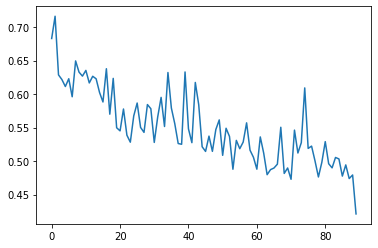

Training done.
Model saved.


In [21]:
loss_visual = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()
        # print((epoch + 1, i + 1, running_loss))
        loss_visual.append(running_loss)
        clear_output(wait=True)
        plt.plot(loss_visual)
        plt.show()
        running_loss = 0.0

print('Training done.')

# save trained model
torch.save(net.state_dict(), 'saved_model.pt')
print('Model saved.')

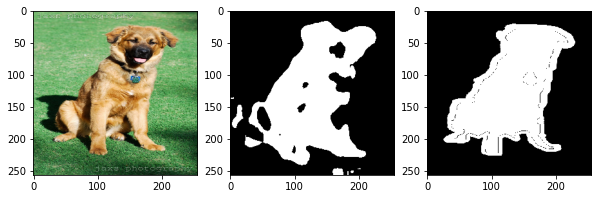

In [27]:
testset = Oxpet_Dataset(os.path.join("datasets-oxpet", "test","images.h5"),os.path.join("datasets-oxpet", "test","binary.h5"),os.path.join("datasets-oxpet", "test","bboxes.h5"),os.path.join("datasets-oxpet", "test","masks.h5"), require_binary=False, require_bbox=False)
testloader = DataLoader(testset, batch_size=1, shuffle= True, num_workers=2)
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = torch.sigmoid(net(images.to(device)))
output = outputs[0].cpu().reshape(256,256).detach()
output[output>=0.5] = 1
output[output<0.5] = 0
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(images[0].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(output,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(labels.reshape(256,256),cmap='gray')
plt.show()

In [28]:
labels.unique()

tensor([0., 1.])

In [29]:
output.unique()

tensor([0., 1.])